In [24]:
import sys
sys.path.append('../')

from quantumsim import *
import pennylane as qml
from pennylane import numpy as np
import dask


In [25]:
def molecular_energies(symbols, coordinates, basis_set, charge=0):
    multiplicity = 1
    # Generate the molecular Hamiltonian
    hamiltonian = qml.qchem.molecular_hamiltonian(
        symbols = symbols,
        coordinates = coordinates,
        basis=basis_set,
        charge=charge,
        mult=multiplicity
    )[0]

    # Obtain the matrix representation of the Hamiltonian
    ee = qml.eigvals(hamiltonian)
    return np.sort(ee)

In [30]:
symbols = ["He", "H"]
coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 1.4588], requires_grad=True)
hamil, qubits = qchem.molecular_hamiltonian( symbols= symbols, coordinates= coordinates, charge=1)
coeff, terms = hamil.terms()
terms, coeff = qml.pauli.group_observables(observables=terms, coefficients=coeff, grouping_type='qwc', method='rlf')

In [32]:
molecular_energies(symbols, coordinates, "sto-3g", charge=1)[0]

/Users/jnorambu/Documents/vqesimulation/venv/lib/python3.9/site-packages/pennylane/ops/functions/eigvals.py:108: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires. Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


tensor(-3.01345118, requires_grad=True)

In [37]:
dev = qml.device('default.qubit', wires=4)
begin_state = qml.qchem.hf_state(electrons=2, orbitals=qubits)
singles, doubles = qml.qchem.excitations(2, qubits)
singles, doubles = qml.qchem.excitations_to_wires(singles, doubles)

def circuit2(theta, index):
    qml.UCCSD(theta, range(qubits), singles, doubles, begin_state)
    return [qml.expval(u) for u in terms[index]]


node = qml.QNode(circuit2, dev)

def process_group(theta, i):
    result_probs = node(theta=theta, index=i)
    return np.sum( coeff[i]*np.array(result_probs) )

def cost_function(theta):
    results = []
    for i in range(len(terms)):
        results.append( dask.delayed(process_group)(theta, i) )
    num_workers = 1
    result = dask.compute(*results, scheduler="processes", num_workers=num_workers)
    return np.sum( result )

number = len(singles) + len(doubles)
theta = np.random.random( size=number )*(np.pi/180.0)

#energy = cost_function(theta)

theta_optimizer = qml.GradientDescentOptimizer(stepsize=0.3)
energy = [cost_function(theta)]
theta_evol = [theta]
for _ in range(40):
    theta.requires_grad = True
    theta = theta_optimizer.step(cost_function, theta)
    energy.append(cost_function(theta))
    theta_evol.append(theta)
    prev_energy = energy[len(energy)-2]
    print(energy[-1])
    conv = np.abs(energy[-1] - prev_energy)
    if conv <= 1e-6:
        break

-2.842922401175041
-2.844331899170548
-2.8456050894541005
-2.8467417568572606
-2.8477417680441994
-2.848605071538139
-2.8493316976282554
-2.84992175815754
-2.8503754461923787
-2.850693035574989
-2.8508748803599833
-2.850921414136976
-2.850833149241095
-2.8506106758537606
-2.850254660996296
-2.8497658474192016
-2.8491450523903055
-2.8483931663849087
-2.847511151681785
-2.846500040868571
-2.8453609352606564
-2.8440950032377565
-2.8427034785023695
-2.8411876582647455
-2.839548901358798
-2.8377886262938676
-2.8359083092469124
-2.833909482000205
-2.8317937298293683
-2.8295626893466936
-2.8272180463048264
-2.824761533365758
-2.822194927840089
-2.8195200494016315
-2.81673875778207
-2.8138529504507317
-2.8108645602841293
-2.807775553229987
-2.804587925970314
-2.8013037035880988


In [34]:
def process_group(theta, i):
    result_probs = circuit2(theta=theta, index=i)
    return np.sum( coeff[i]*np.array(result_probs) )

def cost_function(theta):
    results = []
    for i in range(len(terms)):
        results.append( process_group(theta, i) )
    return np.sum( results )


number = len(singles) + len(doubles)
theta = np.random.random( size=number )*(np.pi/180.0)

#energy = cost_function(theta)

theta_optimizer = qml.GradientDescentOptimizer(stepsize=0.3)
energy = [cost_function(theta)]
theta_evol = [theta]
for _ in range(100):
    theta.requires_grad = True
    theta = theta_optimizer.step(cost_function, theta)
    energy.append(cost_function(theta))
    theta_evol.append(theta)
    prev_energy = energy[len(energy)-2]
    print(energy[-1])
    conv = np.abs(energy[-1] - prev_energy)
    if conv <= 1e-6:
        break

-2.8476137116713525
-2.849440163763465
-2.8502495953585654
-2.850620687774452
-2.8507990121033946
-2.850889809248206
-2.850939047570366
-2.8509674148612305
-2.850984623061783
-2.850995484618781
-2.8510025363956983
-2.8510072022092694
-2.851010327361448
-2.851012436839692
-2.8510138676545393
-2.8510148411068257


In [6]:
ansatz_params = {
    "repetitions": 1,
    "base": "default.qubit",
    "backend": None,
    "interface": "autograd",
    "shots": 1000.0,
    "token": None,
    "pattern": "chain"
}

# Seteo de hiperparametros del circuito
molecule.set_device( ansatz_params )
molecule.set_node( ansatz_params )

rep = molecule.qubits*ansatz_params["repetitions"]

In [7]:
minimizate_params = {
    "type": "SLSQP",
    "maxiter": 100,
    "tol": 0.000001,
    "step_theta":0.4,
    "step_x":0.8,
    "number": molecule.qubits*ansatz_params["repetitions"]}

# Ejecucion del optimizador para calcular los niveles 
# de energia

optimizer = gradiend_optimizer(minimizate_params)
#optimizer.set_constrains()

energy, optimum = optimizer.OS(molecule.cost_function, coordinates, molecule.grad_x)

KeyboardInterrupt: 

In [13]:
molecule.coordinates

tensor([ 0. ,  0. , -0.7,  0. ,  0. ,  0.7], requires_grad=True)

In [16]:
np.round(optimum[:6],4)

tensor([ 0.    ,  0.    , -1.0021,  0.    ,  0.    ,  1.0021], requires_grad=True)

In [17]:
energy

[]

In [6]:
sz = np.array([[1,0],[0,-1]])
si = np.array([[1,0],[0,1]])
sx = np.array([[1,0],[0,1]])
sy = np.array([[1,0],[0,1]])

h = -1*( np.kron(sz, sz) + np.kron(sy, sy) + np.kron(sx, sx) )
ee = np.linalg.eigvals(h)
print(ee)

[-3. -1. -1. -3.]


In [2]:
params = {
    "sites": 3,
    "spin": 0.5, 
    "pattern": "open",
    "exchange": [1,1,1]
}

object_vqe = vqe_spin(params)
object_vqe.set_group_characteristics()

In [3]:
object_vqe.hamiltonian_object

[['XXI', 'IXX'], ['YYI', 'IYY'], ['ZZI', 'IZZ']]

In [3]:
ansatz_params = {
    "repetitions": 2,
    "electrons": 2,
    "pattern": "all_to_all",
    "base": "default.qubit",
    "backend": None,
    "interface": "autograd",
    "shots": 1000.0,
    "token": None,
}

object_vqe.set_device(ansatz_params)
object_vqe.set_node(ansatz_params)

rep = ansatz_params["repetitions"]
number = (object_vqe.qubits)*rep

(<Figure size 1400x400 with 1 Axes>, <Axes: >)

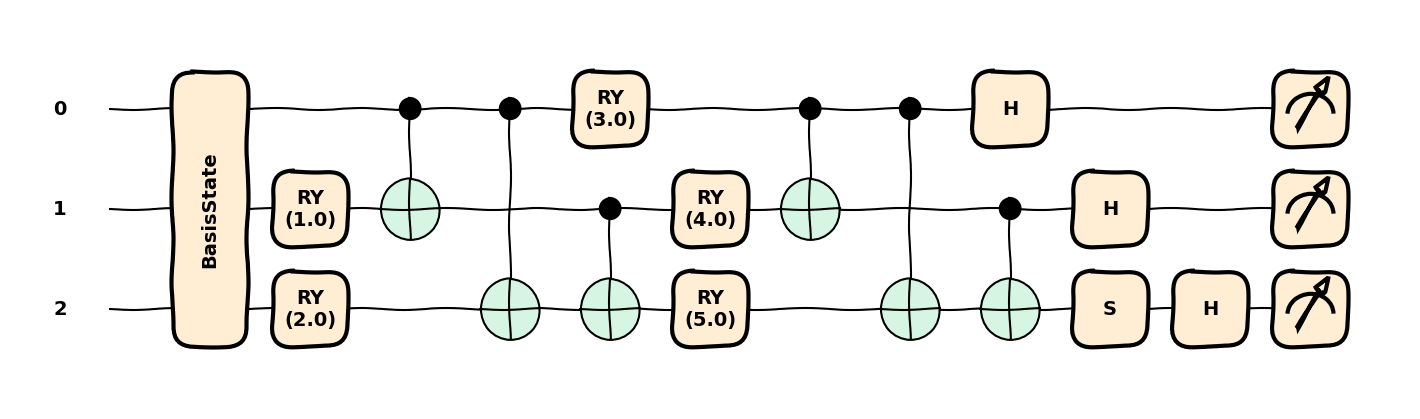

In [4]:
qml.draw_mpl(object_vqe.node, decimals=1, style="sketch")( [i for i in range(20)], ["XXZ"], "XXY", [0,0,0,0,0,0,0,0])

(<Figure size 1400x400 with 1 Axes>, <Axes: >)

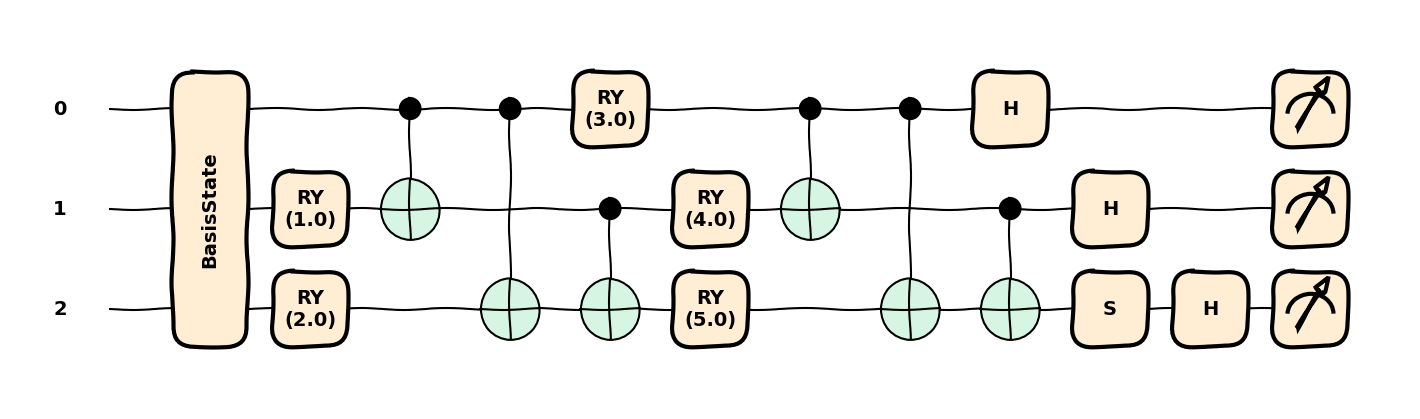

In [16]:
merged_circuit = qml.compile()(object_vqe.circuit)
qnode = qml.QNode(merged_circuit, object_vqe.device)
qml.draw_mpl(qnode, decimals=1, style="sketch")( [i for i in range(20)], ["XXZ"], "XXY", [0,0,0,0,0,0,0,0])

(<Figure size 1800x400 with 1 Axes>, <Axes: >)

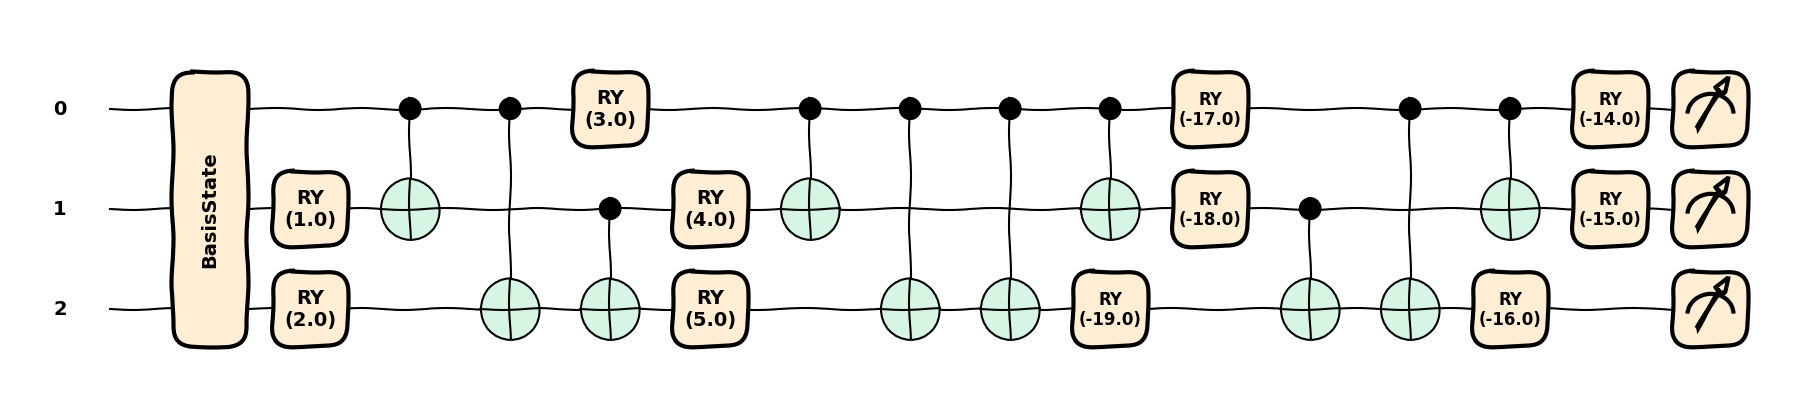

In [5]:
qml.draw_mpl(object_vqe.node_overlap, decimals=1, style="sketch")( [i for i in range(20)], [i for i in range(20)], [0,0,0,0,0,0], [0,0,0,0,0,0])

(<Figure size 1800x400 with 1 Axes>, <Axes: >)

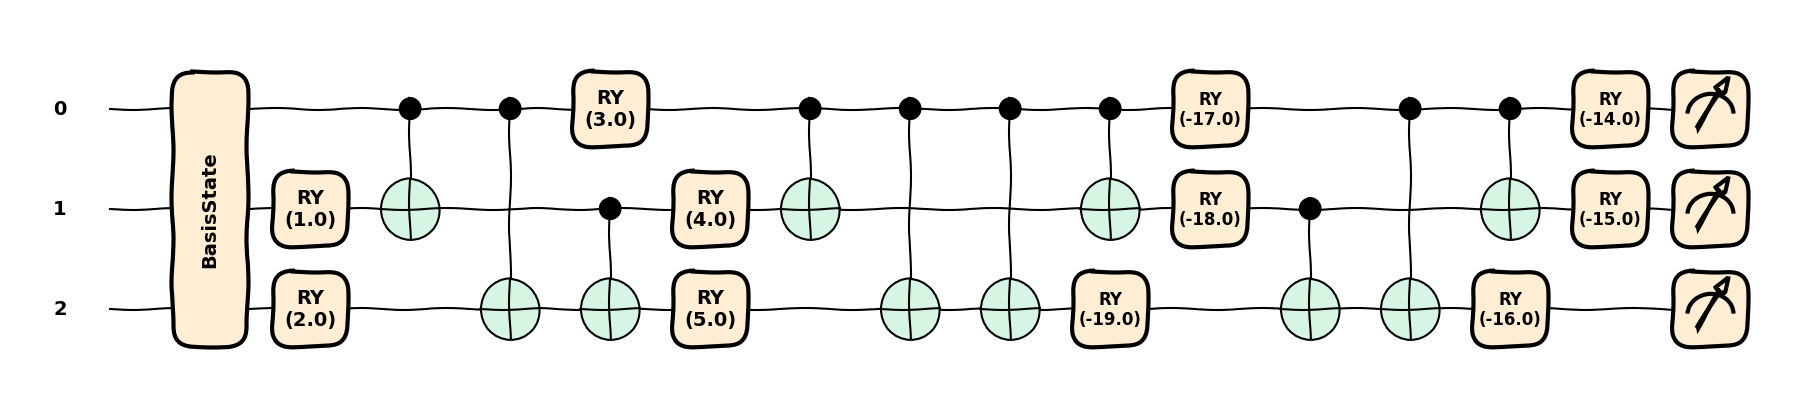

In [19]:
merged_circuit = qml.compile()(object_vqe.circuit_overlap)
qnode = qml.QNode(merged_circuit, object_vqe.device)
qml.draw_mpl(qnode, decimals=1, style="sketch")( [i for i in range(20)], [i for i in range(20)], [0,0,0,0,0,0], [0,0,0,0,0,0])

In [11]:
minimizate_params = {
    "type": "SLSQP",
    "maxiter": 1000,
    "tol": 0.000001,
    "step_theta": 0.4,
    "step_x": 0.8,
    "number": object_vqe.qubits*ansatz_params["repetitions"]}

optimizer = scipy_optimizer(minimizate_params)
optimizer.set_constrains()
theta = np.array( [0.0  for _ in range(object_vqe.qubits*ansatz_params["repetitions"])], requires_grad=True)
energy, optimum = optimizer.VQE(object_vqe.cost_function, theta, object_vqe.qubits)

In [12]:
energy

[tensor(-1., requires_grad=True),
 tensor(-1., requires_grad=True),
 tensor(-1., requires_grad=True),
 tensor(-1., requires_grad=True),
 tensor(-1., requires_grad=True)]

(<Figure size 1200x300 with 1 Axes>, <Axes: >)

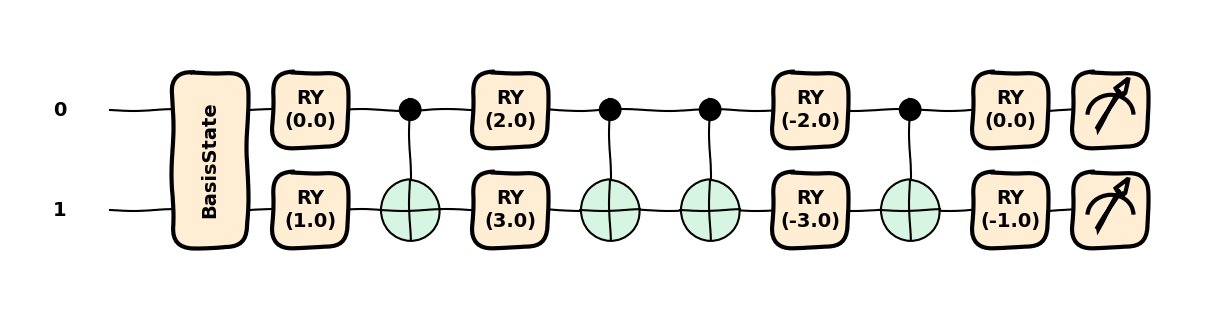

In [13]:
qml.draw_mpl(object_vqe.node_overlap, decimals=1, style="sketch")( [i for i in range(4)], [i for i in range(4)], [0,0,0,0], [0,0,0,0])

In [5]:
ansatz_params = {
    "repetitions": 2,
    "electrons": 2,
    "base": "default.qubit",
    "backend": None,
    "interface": "autograd",
    "shots": 1000.0,
    "token": None,
}

object_vqe.set_device(ansatz_params)
object_vqe.set_node(ansatz_params)

rep = ansatz_params["repetitions"]
number = (object_vqe.qubits)*rep

In [8]:
minimizate_params = {
    "type": "SLSQP",
    "maxiter": 1000,
    "tol": 0.000001,
    "step_theta": 0.4,
    "step_x": 0.8,
    "number": object_vqe.qubits*ansatz_params["repetitions"]}

# Ejecucion del optimizador para calcular los niveles 
# de energia

optimizer = scipy_optimizer(minimizate_params)
optimizer.set_constrains()
theta = np.array( [0.0  for _ in range(object_vqe.qubits*ansatz_params["repetitions"])], requires_grad=True)
energy, optimum = optimizer.VQE(object_vqe.cost_function, theta)

TypeError: circuit() missing 2 required positional arguments: 'characteristic' and 'state'

In [7]:
energy

[tensor(-0.99999975, requires_grad=True),
 tensor(-1., requires_grad=True),
 tensor(0.99999989, requires_grad=True),
 tensor(0.99999917, requires_grad=True)]

In [8]:
theta

[array([3.14138699, 2.20313188, 0.16999992, 2.20242932]),
 array([4.18122105, 1.57079748, 2.27179888, 1.57080014]),
 array([-2.99415959e-04,  3.61409007e-01,  1.94960894e+00, -3.61796839e-01]),
 array([ 1.90530544, -1.56978526,  0.71308162,  1.57026132])]

### Molecular

In [45]:
symbols = ['H', 'H']
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614])

H, qubits = qchem.molecular_hamiltonian(symbols, coordinates, wires=[0,1,2,3])

coeff, terms = H.terms()

In [46]:
terms, coeff = qml.pauli.group_observables(observables=terms,coefficients=coeff, grouping_type='qwc', method='rlf')


In [65]:
Pauli_terms = []
for group in terms:
    aux = []
    for term in group:
        string = Pauli_function(term, 4)
        aux.append(string)   
    Pauli_terms.append(aux)

In [66]:
Pauli_terms

[['IIII', 'YXXY'],
 ['YYXX'],
 ['XXYY'],
 ['XYYX'],
 ['ZIII',
  'IZII',
  'ZZII',
  'IIZI',
  'ZIZI',
  'IIIZ',
  'ZIIZ',
  'IZZI',
  'IZIZ',
  'IIZZ']]

In [58]:
dev = qml.device("default.qubit", wires=4)

@qml.qnode(dev, interface="autograd")
def circuit(group, **kwargs):
    qml.BasisState([0 for _ in range(4)], wires=range(4))
    return [qml.probs(wires=o.wires) for o in group]

In [60]:
terms[0][0].wires

<Wires = [0]>

In [59]:
circuit(terms[0])

[tensor([1., 0.], requires_grad=True),
 tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)]

In [10]:
si = np.array([[1,0],[0,1]], dtype="complex64")
sz = np.array([[1,0],[0,-1]], dtype="complex64")
sx = np.array([[0,1],[1,0]], dtype="complex64")
sy = np.array([[0,-1j],[1j,0]], dtype="complex64")

H = coeff[0]*np.kron( np.kron(si,si), np.kron(si,si) ) + coeff[1]*np.kron( np.kron(sz,si), np.kron(si,si) ) + coeff[2]*np.kron( np.kron(si,sz), np.kron(si,si) )
H += coeff[3]*np.kron( np.kron(sz,sz), np.kron(si,si) ) + coeff[4]*np.kron( np.kron(sy,sx), np.kron(sx,sy) ) + coeff[5]*np.kron( np.kron(sy,sy), np.kron(sx,sx) )
H += coeff[6]*np.kron( np.kron(sx,sx), np.kron(sy,sy) ) + coeff[7]*np.kron( np.kron(sx,sy), np.kron(sy,sx) ) + coeff[8]*np.kron( np.kron(si,si), np.kron(sz,si) )
H += coeff[9]*np.kron( np.kron(sz,si), np.kron(sz,si) ) + coeff[10]*np.kron( np.kron(si,si), np.kron(si,sz) ) + coeff[11]*np.kron( np.kron(sz,si), np.kron(si,sz) )
H += coeff[12]*np.kron( np.kron(si,sz), np.kron(sz,si) ) + coeff[13]*np.kron( np.kron(si,sz), np.kron(si,sz) ) + coeff[14]*np.kron( np.kron(si,si), np.kron(sz,sz) )

In [5]:
symbols = ['H', 'H']
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614])
params = {
    "mapping": "jordan_wigner",
    "charge": 0, 
    "mult": 1,
    "basis": 'sto-3g',
    "method": 'dhf'
}

hamiltonian_object = variational_quantum_eigensolver_electronic(symbols, coordinates, params)

In [6]:
ansatz_params = {
    "repetitions": 3,
    "electrons": 3,
    "base": "default.qubit",
    "backend": None,
    "interface": "autograd",
    "shots": 1000.0,
    "token": None,
}

hamiltonian_object.set_device( ansatz_params )
#hamiltonian_object.set_hiperparams_circuit( ansatz_params )
hamiltonian_object.set_node( ansatz_params )

rep = ansatz_params["repetitions"]

In [13]:
minimizate_params = {
    "type": "SLSQP",
    "maxiter": 100,
    "tol": 0.000001,
    "step_theta": 0.4,
    "step_x": 0.8
}

#energy, theta_evol, theta = gradiend_method_VQE(hamiltonian_object.cost_function, theta, minimizate_params)
energy, optimum = scipy_method_VQD(hamiltonian_object.cost_function, hamiltonian_object.overlap_cost_function, 16, minimizate_params)

In [14]:
np.sort(energy)

tensor([-1.13618892, -0.52188334, -0.52186317, -0.47844685, -0.47843727,
        -0.47821364, -0.4031787 , -0.40317794, -0.12044661,  0.30767533,
         0.30767546,  0.44899833,  0.4490921 ,  0.58332556,  0.75597186,
         1.01609576], requires_grad=True)

In [11]:
np.linalg.eigvalsh(H)

tensor([-1.1361891 , -0.52188355, -0.52188349, -0.47844693, -0.47844693,
        -0.4784469 , -0.40317875, -0.40317875, -0.12044625,  0.30767557,
         0.3076756 ,  0.44909644,  0.4490965 ,  0.58332568,  0.75597221,
         1.01609778], dtype=float32, requires_grad=True)